In [ ]:

#import the libraries 
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, Dropout, MaxPooling2D, UpSampling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

# Load MNIST dataset
(input_train_1, target_train_1), (input_test_1, target_test_1) = mnist.load_data()

In [ ]:

print(input_train_1.shape)
print(input_test_1.shape)
print(target_train_1.shape)
print(target_test_1.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [ ]:
input_train=input_train_1[0:10000]
target_train=target_train_1[0:10000]
input_test=input_test_1[0:1000]
target_test=target_test_1[0:1000]

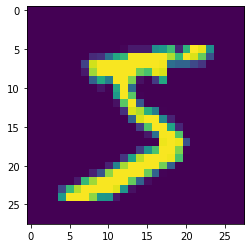

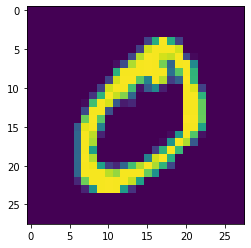

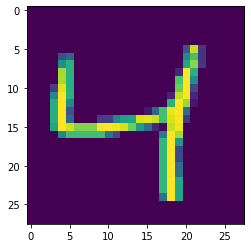

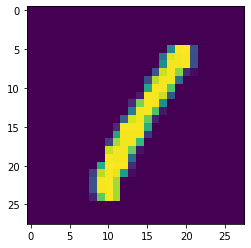

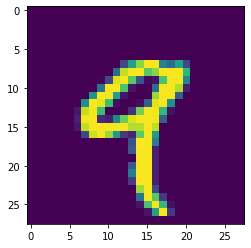

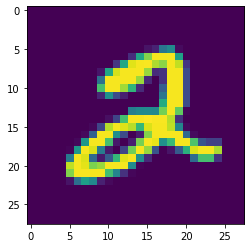

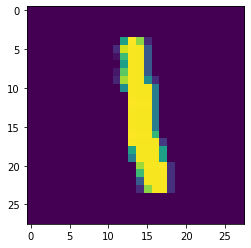

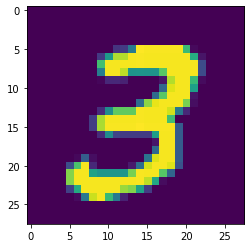

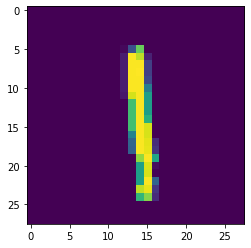

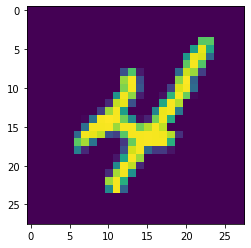

In [ ]:
for i in range(10):
  pr_image = input_train[i]
  pr_image = np.array(pr_image, dtype='float')
  pixels = pr_image.reshape((28, 28))
  plt.imshow(pixels)
  plt.show()

In [ ]:
print(input_train.shape)
print(input_test.shape)
print(target_train.shape)
print(target_test.shape)

(10000, 28, 28)
(1000, 28, 28)
(10000,)
(1000,)


In [ ]:

# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 50
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

In [ ]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

In [ ]:
# Encoder Definition
i       = Input(shape=input_shape, name='encoder_input')

cx      = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

In [ ]:

# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

In [ ]:
# Define sampling with reparameterization trick
def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

In [ ]:
z= Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

In [ ]:

# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 28, 28, 64)   1664        encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 28, 28, 64)   256         conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 28, 28, 32)   51232       batch_normalization_30[0][0]     
____________________________________________________________________________________________

In [ ]:
d_i   = Input(shape=(latent_dim, ), name='decoder_input')

x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(cx)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(cx)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(cx)
cx    = BatchNormalization()(cx)

o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)




In [ ]:
# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 6272)              18816     
_________________________________________________________________
batch_normalization_35 (Batc (None, 6272)              25088     
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 28, 28, 8)         1608      
_________________________________________________________________
batch_normalization_36 (Batc (None, 28, 28, 8)         32        
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 28, 28, 16)        3216

In [ ]:

# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 195024    
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         113881    
Total params: 308,905
Trainable params: 295,841
Non-trainable params: 13,064
_________________________________________________________________


In [ ]:
tf.config.run_functions_eagerly(True)
# Compile VAE
vae.compile(optimizer='adam', loss='binary_crossentropy')

# Train autoencoder
vae.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

Epoch 1/50
 1/63 [..............................] - ETA: 0s - loss: 0.8648

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


63/63 [==============================] - 3s 50ms/step - loss: 0.4673 - val_loss: 0.4126
Epoch 2/50
63/63 [==============================] - 3s 47ms/step - loss: 0.2699 - val_loss: 0.3656
Epoch 3/50
63/63 [==============================] - 3s 48ms/step - loss: 0.2562 - val_loss: 0.3466
Epoch 4/50
63/63 [==============================] - 3s 47ms/step - loss: 0.2342 - val_loss: 0.3685
Epoch 5/50
63/63 [==============================] - 3s 48ms/step - loss: 0.2257 - val_loss: 0.5419
Epoch 6/50
63/63 [==============================] - 3s 46ms/step - loss: 0.2192 - val_loss: 0.5343
Epoch 7/50
63/63 [==============================] - 3s 46ms/step - loss: 0.2160 - val_loss: 0.5868
Epoch 8/50
63/63 [==============================] - 3s 47ms/step - loss: 0.2107 - val_loss: 0.6264
Epoch 9/50
63/63 [==============================] - 3s 48ms/step - loss: 0.2088 - val_loss: 0.6520
Epoch 10/50
63/63 [==============================] - 3s 48ms/step - loss: 0.2061 - val_loss: 0.6503
Epoch 11/50
63/63 [=

In [ ]:
# Credits for original visualization code: https://keras.io/examples/variational_autoencoder_deconv/


def viz_latent_space(encoder, data):
  input_data, target_data = data
  mu, _, _ = encoder.predict(input_data)
  plt.figure(figsize=(8, 10))
  plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  plt.colorbar()
  plt.show()

In [ ]:
def viz_decoded(encoder, decoder, data):
  num_samples = 15
  figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
  grid_x = np.linspace(-4, 4, num_samples)
  grid_y = np.linspace(-4, 4, num_samples)[::-1]
  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded[0].reshape(img_width, img_height, num_channels)
          figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
  plt.figure(figsize=(10, 10))
  start_range = img_width // 2
  end_range = num_samples * img_width + start_range + 1
  pixel_range = np.arange(start_range, end_range, img_width)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
  # So reshape if necessary
  fig_shape = np.shape(figure)
  if fig_shape[2] == 1:
    figure = figure.reshape((fig_shape[0], fig_shape[1]))
  # Show image
  plt.imshow(figure)
  plt.show()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


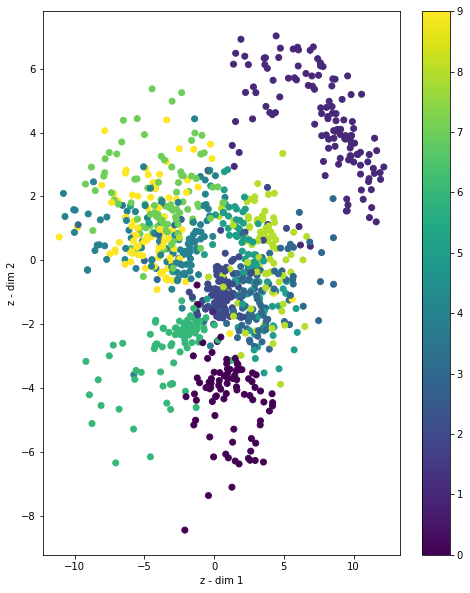

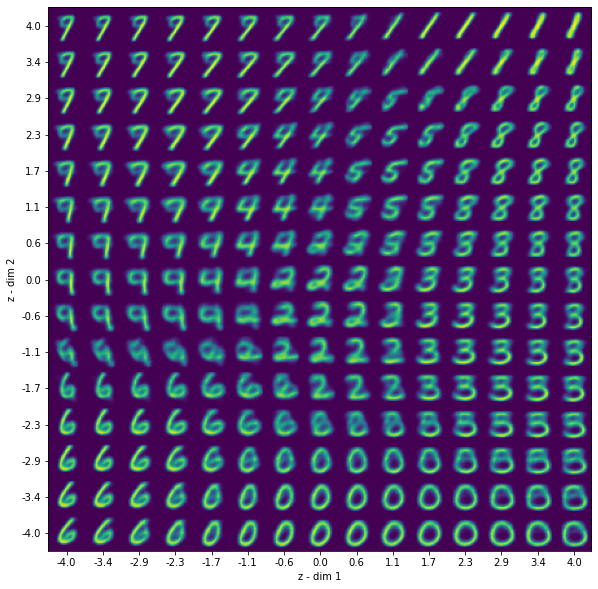

In [ ]:

# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)
viz_decoded(encoder, decoder, data)